In [1]:
import numpy as np
import concurrent.futures
from tqdm.notebook import tqdm
import os
import matplotlib as mpt
import matplotlib.pyplot as plt
from matplotlib import style
import pylab
#speed things up
import numba
from numba import njit
from numba import jit
from numba import prange
from numba.experimental import jitclass
from scipy.optimize import curve_fit
#from numba_progress import ProgressBar
#from scipy.ndimage import convolve, generate_binary_structure
from timeit import default_timer as timer
from time import sleep
#style designed by me for plottin (version 2)
plt.style.use(['science','notebook','grid'])
plt.rcParams['mathtext.fontset'] = 'stix'

fig = (9,6)
params = {'figure.figsize': fig,
        'legend.fontsize': 2.5*fig[1],
         'axes.labelsize': 2.8*fig[1],
         'axes.titlesize': 4*fig[1],
         'xtick.labelsize': 2*fig[1],
         'ytick.labelsize': 2*fig[1],
         'font.family' : 
          'Stixgeneral'
          }
pylab.rcParams.update(params)

In [2]:
def getColor(c, N, idx):
    cmap=mpt.colormaps.get_cmap(c)
    norm = mpt.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

In [3]:
#definiamo la classe che conterrà tutte le info che ci servono 
class Particle:
    def __init__(self, beta, N, tailor_prob):
        self.beta = beta
        self.N = int(N)
        self.eta = beta/N
        self.path = init(self.N,0)    
        self.npp = boundaries(N)[0]
        self.nmm = boundaries(N)[1]
        self.prob = tailor_prob
    def charge(self):
        self.Q = topological_charge(self.path)
    def energy(self):
        self.K = kinetic_energy(self.path, self.eta)
    def tailor(self):
        tailor_move(self.prob, self.path, self.eta, self.nmm)
    def metro(self):
        update_metro(self.path, self.nmm, self.npp, np.sqrt(self.eta), self.eta)
    def montec(self,N_step,save_measure, name):
        names = os.getcwd() + '/' + 'sim_b50' + '/' + 'simulation'
        Q = np.zeros(int(N_step/save_measure))
        K = np.zeros(int(N_step/save_measure))
        for i in tqdm(range(N_step)):
            self.tailor()
            self.metro()
            if(i%save_measure ==0):
                self.charge()
                self.energy()
                Q[int(i/10)] = self.Q
                K[int(i/10)] = self.K
        full_array = np.stack([Q,K], axis=1)
        np.savetxt(f'{names}_{name}.txt', full_array, delimiter='\t', header='Top_Charge \t Energy')
                    
    def write_on_txt(self):
        pass
        

In [30]:
a=np.geomspace(0.001,1,200)
b=np.geomspace(0.001,0.00103,30)
N = np.unique((10/a).astype(int))
N1 = np.unique((10/b).astype(int))
N2 = np.concatenate((N,N1))
N2[:-1]

array([   10,    11,    12,    13,    14,    15,    16,    17,    18,
          19,    20,    21,    22,    23,    24,    25,    26,    27,
          28,    29,    30,    31,    32,    33,    34,    36,    37,
          38,    40,    41,    42,    44,    46,    47,    49,    51,
          52,    54,    56,    58,    60,    62,    65,    67,    69,
          72,    74,    77,    80,    83,    86,    89,    92,    95,
          98,   102,   105,   109,   113,   117,   121,   126,   130,
         135,   139,   144,   149,   155,   160,   166,   172,   178,
         184,   191,   197,   204,   212,   219,   227,   235,   243,
         252,   261,   270,   280,   289,   300,   310,   321,   333,
         344,   357,   369,   382,   396,   410,   424,   439,   455,
         471,   488,   505,   523,   541,   560,   580,   601,   622,
         644,   666,   690,   714,   740,   766,   793,   821,   850,
         880,   911,   943,   977,  1011,  1047,  1084,  1122,  1162,
        1203,  1245,

In [ ]:
a=np.geomspace(0.001,0.00103,30)
N = np.unique((10/a).astype(int))
N

In [ ]:
a=np.geomspace(0.001,1,200)
N = np.unique((10/a).astype(int))
os.mkdir('sim_b10_metro')
names = os.getcwd() + '/' + 'sim_b10_metro' + '/' + 'simulation'
acc_dir = os.getcwd() + '/' + 'sim_b10_metro' + '/' + 'acc'
os.mkdir(acc_dir)
acc_dir = acc_dir + '/' + 'acc'
with concurrent.futures.ThreadPoolExecutor() as executor:
    for ns in N2[:-1]:
        executor.submit(montecarlo_, 1000000, 10, names, str(ns), ns, acc_dir)

In [ ]:
names = os.getcwd() + '/' + 'sim_b10' + '/' + 'simulation' 
x, y = np.loadtxt(f'{names}_10000.txt', unpack=True)

In [ ]:
plt.plot(x,'+')
#plt.xlim(1000,5000)

In [ ]:
names = os.getcwd() +'/' + 'simulation'
montecarlo_(100000,10,names, 'prova10000', 10000,names)

In [ ]:
names = os.getcwd() +'/' + 'simulation'
x, y = np.loadtxt(f'{names}_prova10000.txt', unpack=True)

In [ ]:
plt.plot(x)

In [ ]:
p5 = Particle(10, 10000, 0.07)
p5.charge()
p5.Q

In [ ]:
plt.plot(p5.path)
plt.xlim(-10,700)

In [ ]:
plt.plot(x)
plt.xlim(-10,10)

In [4]:
def montecarlo_(N_step, save_measure, names, name, ns, acc_dir):
    Q = np.zeros(int(N_step/save_measure))
    K = np.zeros(int(N_step/save_measure))
    acc = 0
    
    p = Particle(10, ns, 1)
    for i in tqdm(range(N_step)):
        tailor_move(p.prob, p.path, p.eta, p.nmm)
        acc = update_metro(p.path, p.nmm, p.npp, np.sqrt(p.eta), p.eta, acc)
        if(i%save_measure ==0):
            p.charge()
            p.energy()
            Q[int(i/10)] = p.Q
            K[int(i/10)] = p.K
    fin_acc =np.ones(1) * acc/(ns * N_step)
    full_array = np.stack([Q,K], axis=1)
    np.savetxt(f'{names}_{name}.txt', full_array, delimiter='\t', header='Top_Charge \t Energy') 
   # np.savetxt(f'{acc_dir}_{name}.txt', fin_acc, delimiter='\t', header='Acceptance' )

In [5]:
@jit(parallel=True)
def init(N_path, flag):
    if flag == 1:
        field = np.random.rand(N_path)
    elif flag ==0:
        field = np.zeros(N_path)
    else:
        print('Accettati solo 1 o 0 --> caldo o freddo')
        return
    
    return field

In [7]:
def fractional_part(x):
    return np.abs(np.modf(x)[0])


In [6]:
@njit('f8(f8,f8)')
def sign_distance(x, y):
    d = x-y
    if (d > 0.5): return d-1
    elif (d < -0.5): return 1+d
    else:
        return d    

In [8]:
@njit(parallel=True)
def topological_charge(field):
    # Q= np.sum([sign_distance(field[(i+1)%len(field)],field[i]) for i in range(len(field))])
    # return round(Q)      # a numba non piace questa implementazione
    Q=0
    for i in prange(len(field)):
        Q+=sign_distance(field[(i+1)%len(field)], field[i])
    return round(Q)   

In [9]:
#eta
@njit(parallel = True)
def kinetic_energy(field, eta):
    K = 0
    for i in prange(len(field)):
        K += (field[(i+1)%len(field)] - field[i])**2
        
    return 0.5 * K/(len(field)*eta**2)

In [10]:
# eta np e nm
@njit
def tailor_move(tailor_prob, field, eta, nmm):
    proposed_cut = 0
    accepted_cut = 0 
    if (tailor_prob >=0 and np.random.uniform(0,1) < tailor_prob):
        cutting_index = 0
        condition = False 
        y_0 = field[np.random.randint(0,len(field))]
        y_r = (y_0 + 0.5)%1
        
        while (cutting_index < len(field) and not(condition)):
            condition = np.abs(sign_distance(field[cutting_index], y_r)) <= 0.02*eta
            cutting_index+=1
        
        if(condition):
            cutting_index-=1
            d_old = sign_distance(field[cutting_index],field[nmm[cutting_index]])
            d_new = sign_distance((2*y_r - field[cutting_index])%1, field[nmm[cutting_index]])
            DeltaS = (d_new**2 - d_old**2)/(2*eta)
            
            proposed_cut+=1
            if((np.exp(-DeltaS) > 1) or np.log(np.random.uniform(0,1)) < -DeltaS):
                accepted_cut+=1
                for i in range(cutting_index, len(field)):
                    field[i] = (2 * y_r - field[i])%1

In [11]:
@njit
def boundaries (n):
    npp = np.zeros(n).astype(np.int64)
    nmm = np.zeros(n).astype(np.int64)

    for i in range(n):
        npp[i] = i+1
        nmm[i] = i-1
    npp[n - 1] = 0
    nmm[0] = n - 1
    return npp,nmm

In [12]:
@njit
def update_metro(field, nmm, npp, delta, eta, acc):
    for i in range(len(field)):
        i_site = np.random.randint(0,len(field))
        y_old = field[i_site]
        y_before = field[nmm[i_site]]
        y_after = field[npp[i_site]]
        y_new = (y_old + delta * (2*np.random.uniform(0,1) - 1))%1
        DeltaS = (1./(2*eta)) * (sign_distance(y_after, y_new)**2 + sign_distance(y_new, y_before)**2 - sign_distance(y_after, y_old)**2 - sign_distance(y_old, y_before)**2)
        
        if( -DeltaS > 0 or np.log(np.random.uniform(0,1)) < -DeltaS):
            acc+=1
            field[i_site] = y_new 
    return acc

### Plotting winding number

In [113]:
pq = Particle(10,2000,1)
pq.charge()
pq.Q

0

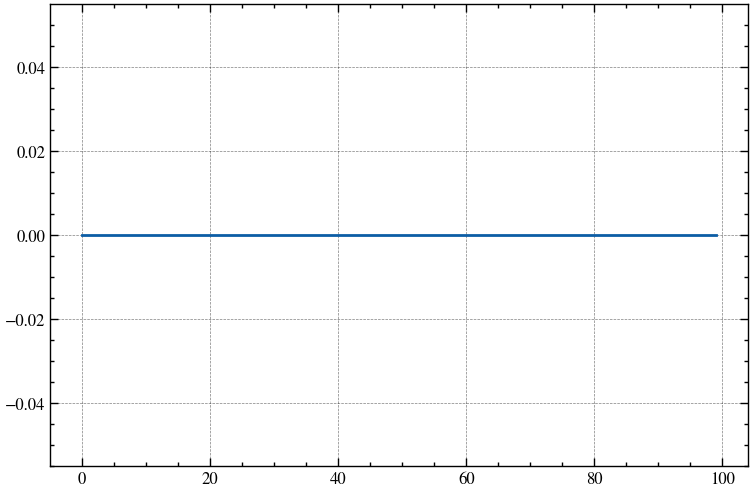

In [29]:
plt.plot(pq.path)

0

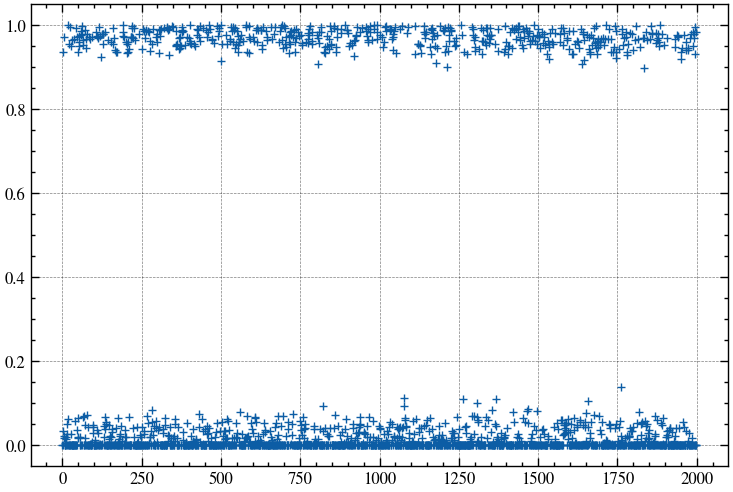

In [114]:
acc=0
acc = update_metro(pq.path, pq.nmm, pq.npp, np.sqrt(pq.eta), pq.eta, acc)
plt.plot(pq.path,'+')
pq.Q

In [115]:
qqq = np.zeros(100000)
for i in tqdm(range(100000)):
    acc = update_metro(pq.path, pq.nmm, pq.npp, np.sqrt(pq.eta), pq.eta, acc)
    pq.charge()
    qqq[i] = pq.Q
    

  0%|          | 0/100000 [00:00<?, ?it/s]

(-10.0, 10.0)

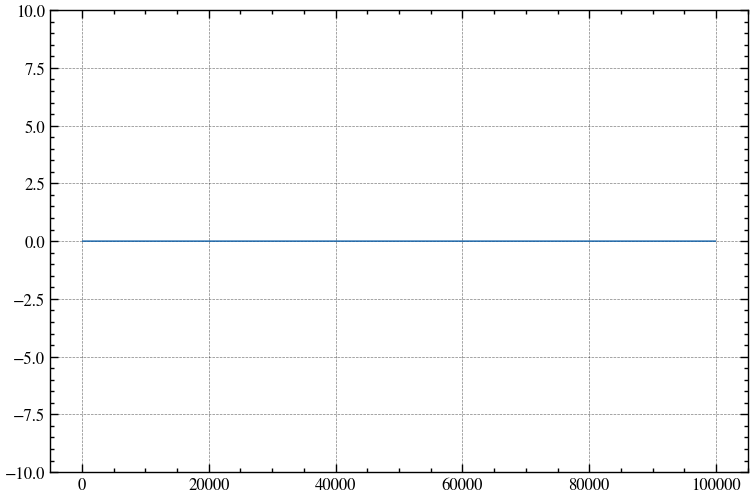

In [116]:
plt.stairs(qqq)
plt.ylim(-10,10)

In [45]:
counts, bins = np.histogram(qqq, int(qqq.max() - qqq.min()))

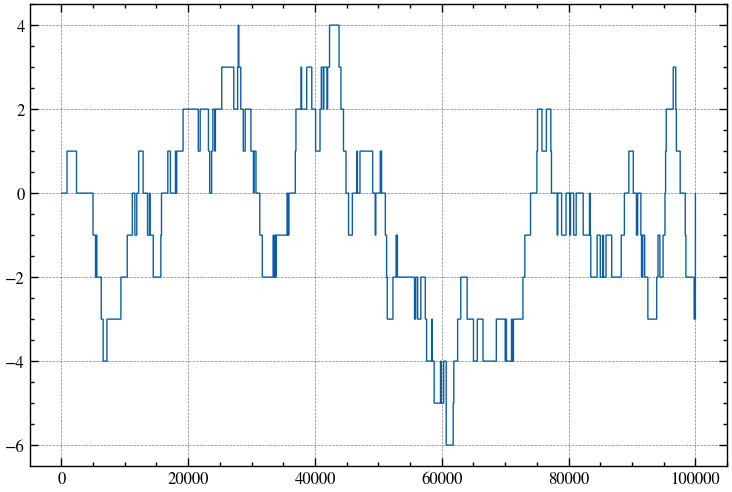

In [112]:
qf =[]
for j in range(1000):
    avg = 0
    avg = int(np.mean(qqq[j*100:(j+1)*100]))
    qf.append(avg)

    
a = 100*np.arange(0,1001,1)
plt.stairs( qf, a)

#plt.stairs(qf)

  0%|          | 0/100000 [00:00<?, ?it/s]

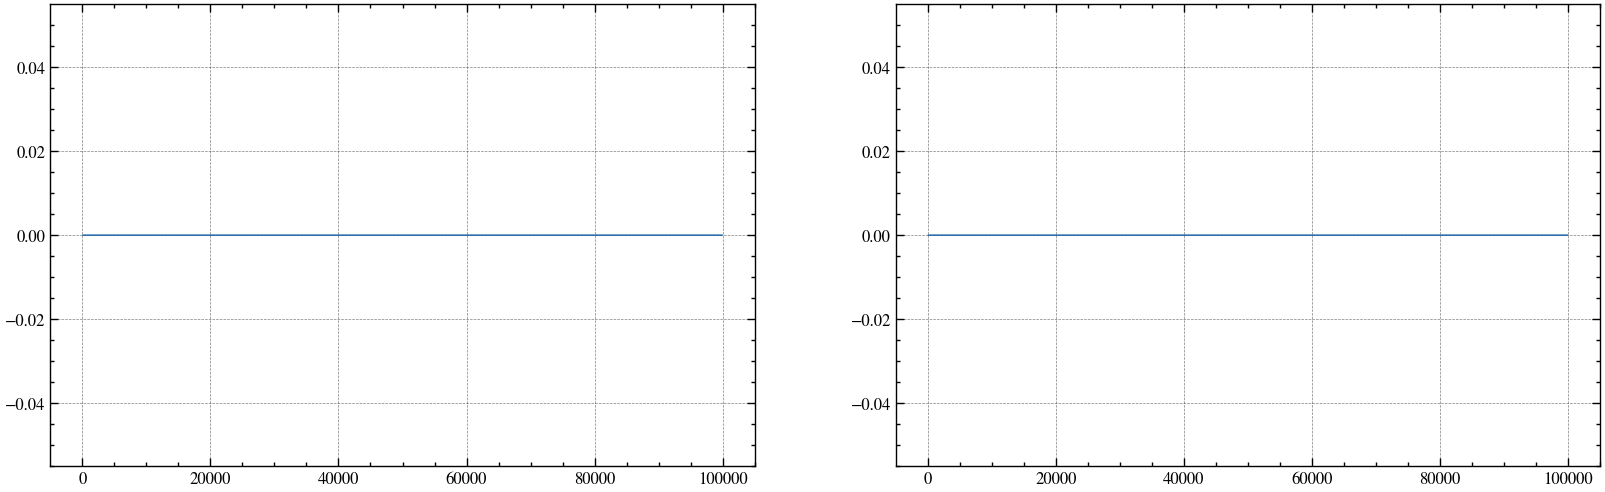

In [122]:
pq1 = Particle(10,3000,1)
pq2 = Particle(10,3000,1)

qqq1 = np.zeros(100000)
qqq2 = np.zeros(100000)
for i in tqdm(range(100000)):
    acc = update_metro(pq1.path, pq1.nmm, pq1.npp, np.sqrt(pq1.eta), pq1.eta, acc)
    acc = update_metro(pq2.path, pq2.nmm, pq2.npp, 0.5, pq2.eta, acc)
    pq1.charge()
    pq2.charge()
    qqq1[i] = pq1.Q
    qqq2[i] = pq2.Q

fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=False)
ax = axes[0]
ax.stairs(qqq1)
ax = axes[1]
ax.stairs(qqq2)

In [235]:
2/5000

0.0004

In [51]:
np.arange(2000)*0.005

array([0.000e+00, 5.000e-03, 1.000e-02, ..., 9.985e+00, 9.990e+00,
       9.995e+00])

In [70]:
for _ in range(10000):
    acc=0
    acc = update_metro(pq.path, pq.nmm, pq.npp, np.sqrt(pq.eta), pq.eta, acc)
    
pq.charge()
pq.Q

0

In [405]:

pq.charge()

pq.Q

0

-1

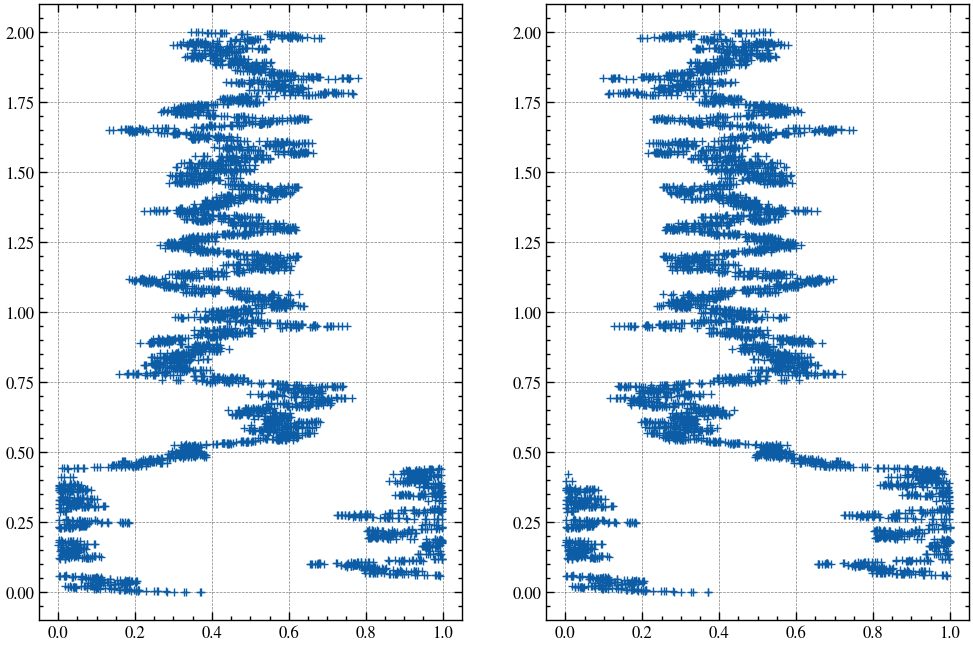

In [432]:
for _ in range(1000):
    acc=0
    acc = update_metro(pq.path, pq.nmm, pq.npp, np.sqrt(pq.eta), pq.eta, acc)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(pq.path, np.arange(0,5000)*0.0004,'+', linewidth=.6)
path_old = pq.path
stop=0
while(pq.Q == 0 and stop <10):
    pq.tailor()
    pq.charge()
    path_new = pq.path
    stop+=1
plt.subplot(1,2,2)
plt.plot(path_new, np.arange(0,5000)*0.0004,'+', linewidth=.6)
pq.Q

In [166]:
pq.tailor()
pq.charge()
pq.Q

0

In [ ]:
tt = np.arange(0,100000,1000)
qq = np.zeros(len(tt))
ee = np.zeros(len(tt))
for j,t in enumerate(tqdm(tt)):
    p = Particle(1,1000,0.1)
    for i in range(t):
        p.tailor()
        p.metro()
    p.charge()
    p.energy()
    qq[j]=p.Q
    ee[j]=p.K

In [ ]:
plt.plot(ee[:])

In [ ]:
tt = np.arange(0,1000000,50000)
qq = np.zeros(len(tt))
ee = np.zeros(len(tt))
qq1 = np.zeros(len(tt))
ee1 = np.zeros(len(tt))
for j,t in enumerate(tqdm(tt)):
    p = Particle(0.01,1000,0.1)
    p1 =Particle(10,1000,0.1)
    for i in range(t):
        p.tailor()
        p.metro()
        p1.tailor()
        p1.metro()
    p1.charge()
    p1.energy()    
    p.charge()
    p.energy()
    qq1[j]=p1.Q
    ee1[j]=p1.K
    qq[j]=p.Q
    ee[j]=p.K

In [ ]:
plt.plot(qq)
plt.plot(qq1)

In [ ]:
plt.plot(ee)
#plt.plot(ee1)

In [ ]:
tt = np.arange(0,500000,100000)
qq = np.zeros(len(tt))
ee = np.zeros(len(tt))
qq1 = np.zeros(len(tt))
ee1 = np.zeros(len(tt))
for j,t in enumerate(tqdm(tt)):
    p = Particle(0.01,1000,0.1)
    p1 =Particle(10,1000,0.1)
    for i in range(t):
        p.tailor()
        p.metro()
        p1.tailor()
        p1.metro()
    p1.charge()
    p1.energy()    
    p.charge()
    p.energy()
    qq1[j]=p1.Q
    ee1[j]=p1.K
    qq[j]=p.Q
    ee[j]=p.K

In [ ]:
def fractional_part1(x):
    if (x > 1): 
        return fractional_part1(x-1);
    elif (x < 0):
        print('a')
        return fractional_part1(x+1);
    return x;


In [18]:
def montecarlo_(N_step, save_measure, names, name, ns):
    Q = np.zeros(int(N_step/save_measure))
    K = np.zeros(int(N_step/save_measure))
    acc = 0
    field = init(ns,1)
    npp, nmm = boundaries(ns)
    for i in tqdm(range(N_step)):
        tailor_move(0.1, field, 10/ns, nmm)
        acc = update_metro(field, nmm, npp, np.sqrt(10/ns), 10/ns, acc)
        if(i%save_measure ==0):
            Q[int(i/10)] = topological_charge(field)
            K[int(i/10)] = kinetic_energy(field, 10/ns)
    fin_acc =np.ones(1) * acc/(ns * N_step)
    full_array = np.stack([Q,K], axis=1)
    np.savetxt(f'{names}_{name}.txt', full_array, delimiter='\t', header='Top_Charge \t Energy')

In [26]:
montecarlo_(1000000, 10, 'simprova', '2000', 2000)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
x = np.arange(0,10,1)
y = np.arange(0,1,0.1)
y

In [ ]:
z = np.stack([x,y], axis =1)
np.savetxt('prova.txt', z, delimiter='\t')